# Random Forest por clasificación

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# split para modelado
from sklearn.model_selection import train_test_split
# Scaled | Escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Encoding | Codificación
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# To save models
import json
import pickle
# Feature Selection
from sklearn.feature_selection import f_classif, SelectKBest
# Modelado
from sklearn.linear_model import LogisticRegression
# Métricas
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, mean_absolute_percentage_error, root_mean_squared_error, r2_score
# Optimizar
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from tqdm import tqdm
import warnings
from utils import get_regression_metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from pickle import dump
from sklearn.tree import DecisionTreeRegressor
from utils import get_classifier_metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor



In [210]:
df_ini = pd.read_csv('../data/processed/df_ini_insulina.csv')



## Split

In [211]:
# Dividimos el conjunto de datos en muestras de train y test
X = df_ini.drop('Outcome', axis=1)
y = df_ini['Outcome']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

In [212]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [213]:
model_forest_clas = RandomForestClassifier(random_state = 42)
model_forest_clas.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


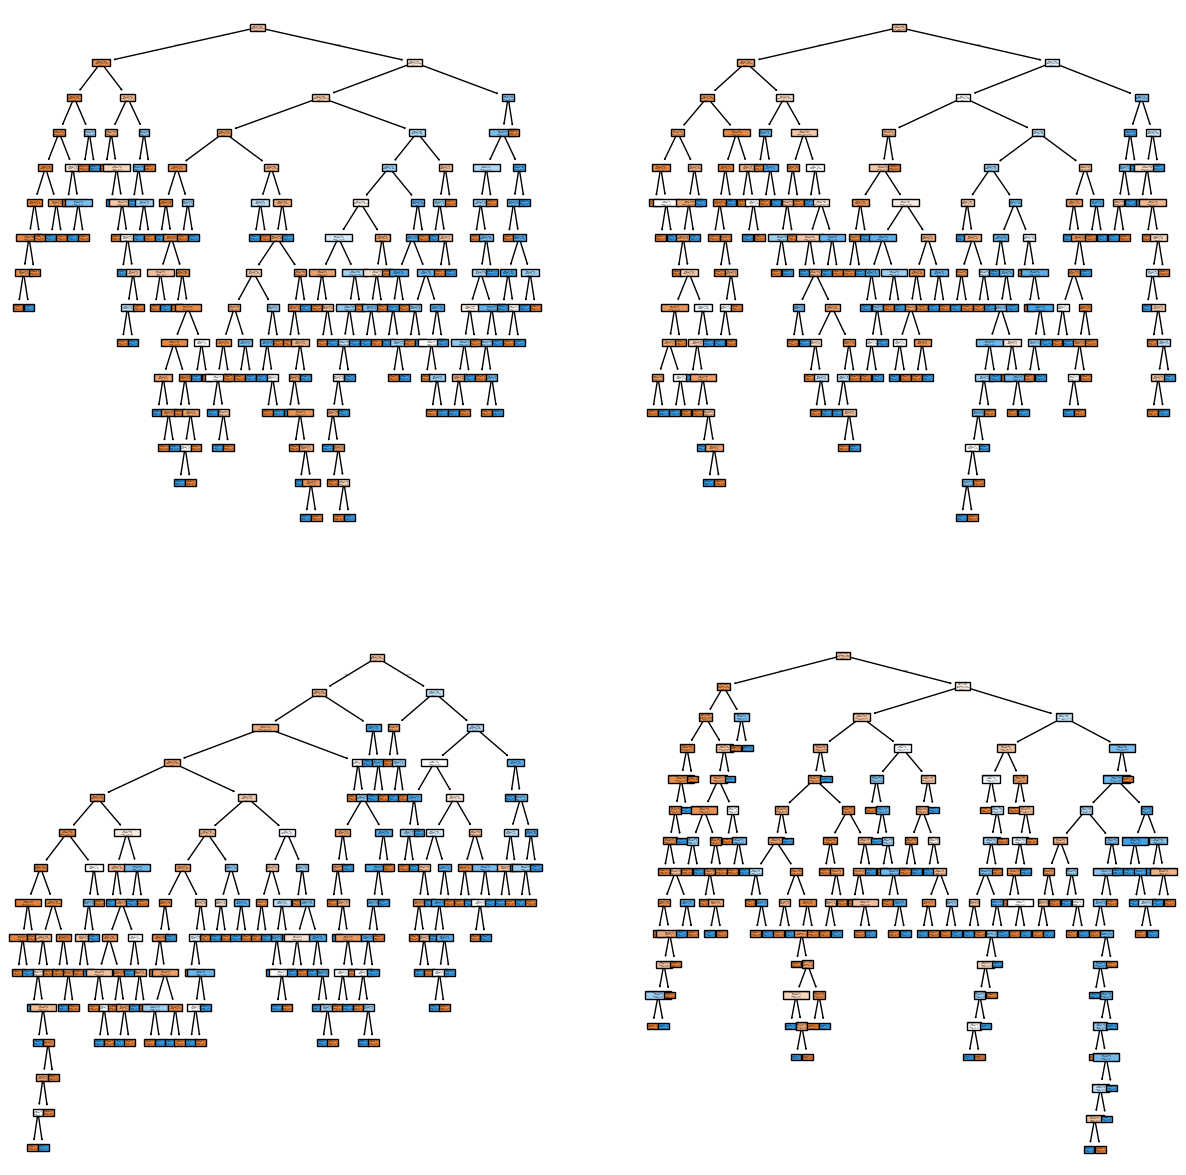

In [214]:
fig, axis = plt.subplots(2, 2, figsize = (15, 15))

# We show the first 4 trees out of the 100 generated (default)
# En class_names porngo 0 o 1 ya que mi Outcome que es mi target es 0 o 1 segun si es positivo o negativo.

tree.plot_tree(model_forest_clas.estimators_[0], ax = axis[0, 0], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(model_forest_clas.estimators_[1], ax = axis[0, 1], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(model_forest_clas.estimators_[2], ax = axis[1, 0], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)
tree.plot_tree(model_forest_clas.estimators_[3], ax = axis[1, 1], feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

In [215]:
y_pred_test = model_forest_clas.predict(X_test)
y_pred_test

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [216]:
y_pred_train = model_forest_clas.predict(X_train)
y_pred_train

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,

In [217]:
get_classifier_metrics(y_pred_test, y_test, y_pred_train, y_train)

,Accuracy,F1 Score,Precision,Recall
Train set,1.000000,1.000000,1.000000,1.000000
Test set,0.772727,0.772727,0.772727,0.772727


In [218]:
get_classifier_metrics(y_pred_test, y_test, y_pred_train, y_train, 'macro')

,Accuracy,F1 Score,Precision,Recall
Train set,1.000000,1.000000,1.000000,1.000000
Test set,0.772727,0.730433,0.801471,0.719447


In [219]:
get_classifier_metrics(y_pred_test, y_test, y_pred_train, y_train, average='weighted')

,Accuracy,F1 Score,Precision,Recall
Train set,1.000000,1.000000,1.000000,1.000000
Test set,0.772727,0.755393,0.789439,0.772727


In [220]:
accuracy_score(y_test, y_pred_test)

0.7727272727272727

> ### Conclusión:
> Nuestro modelo actualmente tiene un 77% de acierto

In [221]:
accuracy_score(y_train, y_pred_train)

1.0

### Hiperparametrización

In [222]:
# Definir hiperparámetros a probar
hparam_foreclas = {'n_estimators': [50, 100, 200],
                   'max_depth': [3, 5, 10],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4]}

# Implementar GridSearchCV
grid_search_foreclas = GridSearchCV(RandomForestClassifier(random_state=18),
                                hparam_foreclas,
                                cv=5,
                                n_jobs=-1,
                                verbose=1)

# Entrenamos
grid_search_foreclas.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
grid_search_foreclas.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


{'max_depth': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

### Best Estimator

In [223]:
# Mejor modelo
grid_search_foreclas.best_estimator_

,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [224]:
# Entrenamos
grid_search_foreclas.best_estimator_.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,5
,min_samples_split,10
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [225]:
y_pred_test_grid = grid_search_foreclas.best_estimator_.predict(X_test)
y_pred_test_grid

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [226]:
y_pred_train_grid = grid_search_foreclas.best_estimator_.predict(X_train)
y_pred_train_grid

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,

In [227]:
get_classifier_metrics(y_pred_test_grid, y_test, y_pred_train_grid, y_train)

,Accuracy,F1 Score,Precision,Recall
Train set,0.848534,0.848534,0.848534,0.848534
Test set,0.766234,0.766234,0.766234,0.766234


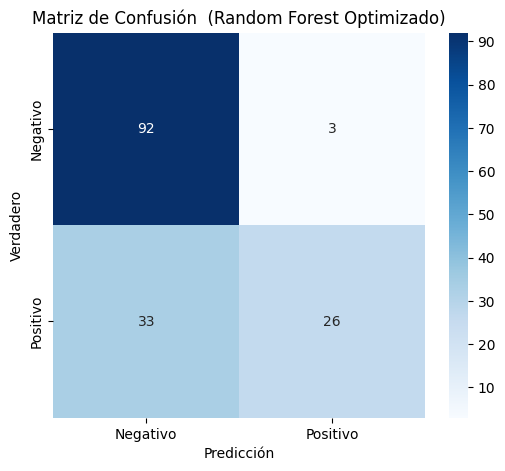

In [228]:
# Obtener el mejor modelo
best_model_insu = grid_search_foreclas.best_estimator_

# Hacer predicciones con el mejor modelo
y_pred_best_insu = best_model_insu.predict(X_test)

# Matriz de confusión
conf_matrix_insu = confusion_matrix(y_test,
                                    y_pred_best_insu)


# Visualización
class_names = ["Negativo", "Positivo"]
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_insu,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de Confusión  (Random Forest Optimizado)")
plt.show()

In [229]:
with open('../models/random_forest_clas_insulina.pkl', 'wb') as file:
    pickle.dump(model_forest_clas, file)

> ### Conslusión:
>
> - Haciendo un random forest por clasificación he conseguido un modelo con un 77% de acierto inicialmente y con la hiperparametrización lo hemos mejorado al 85%
> - De 125 casos analizados como negativo, 92 fueron negativos realmente y 33 positivos. Por lo que hay un 73,6% de acierto y un 26,4% de error.
> - De 29 casos positivos analizados, 26 fueron realmente positivos y 3 negativos. Por lo que hay un 89,65% de acierto y un 10,34% de error.